In [18]:
import numpy as np
import pandas as pd
import seaborn as sns


class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Titanic dataset and survival

In [19]:
titanic.groupby(['sex','survived']).count()

pclass  age  sibsp  parch  fare  embarked  class  who  \
sex    survived                                                          
female 0             81   64     81     81    81        81     81   81   
       1            233  197    233    233   233       231    233  233   
male   0            468  360    468    468   468       468    468  468   
       1            109   93    109    109   109       109    109  109   

                 adult_male  deck  embark_town  alive  alone  
sex    survived                                               
female 0                 81     6           81     81     81  
       1                233    91          231    233    233  
male   0                468    61          468    468    468  
       1                109    45          109    109    109

## Pivot by hand

Group by one column (A), select another column (B), onto which execute an aggregation function

=> we get a table with raws for A-groups, and B-agg column

In [20]:
titanic.groupby(['sex','survived'])['fare'].count()                                             # this is a series

sex     survived
female  0            81
        1           233
male    0           468
        1           109
Name: fare, dtype: int64

In [21]:
titanic.groupby(['sex'])['survived'].mean()                                             # this is a series

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.

In [22]:
titanic.groupby(['sex','class'])['survived'].aggregate('mean')                                             # this is a series

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [23]:
display("titanic.groupby(['sex','class'])['survived'].aggregate('mean').unstack()",
       "titanic.groupby(['sex','class'])['survived'].aggregate('mean').unstack().T")

titanic.groupby(['sex','class'])['survived'].aggregate('mean').unstack()
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

titanic.groupby(['sex','class'])['survived'].aggregate('mean').unstack().T
sex       female      male
class                     
First   0.968085  0.368852
Second  0.921053  0.157407
Third   0.500000  0.135447

# Pivot Table Syntax

In [24]:
# the standard aggfunction is MEAN, though of course it  can be specified
# the agg function gives the 1 number computed in the target column ('survived'),
# for each of the {pivot X columns} pairs, over which groups have been made

# https://dfrieds.com/data-analysis/pivot-table-python-pandas.html

display("titanic.pivot_table('survived', index='sex', columns='class')",
        "titanic.pivot_table('survived', index='class', columns='sex',aggfunc='mean')")

titanic.pivot_table('survived', index='sex', columns='class')
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

titanic.pivot_table('survived', index='class', columns='sex',aggfunc='mean')
sex       female      male
class                     
First   0.968085  0.368852
Second  0.921053  0.157407
Third   0.500000  0.135447

In [25]:
# age = pd.cut?

In [26]:
age = pd.cut(titanic['age'], [0, 18, 80])

# inspect how cut works
# type(age) # Series
# pd_age = pd.DataFrame(age)
# type(pd_age) # Series
# pd_age['orig'] = titanic['age']
# pd_age

titanic.pivot_table('survived', index=['sex',age], columns=['class'] )

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [27]:
fare = pd.qcut(titanic['fare'], 2)
# fare
titanic.pivot_table('survived', index=['sex',age], columns=['class',fare] )

class                      First                             Second  \
fare            (-0.001, 14.454] (14.454, 512.329] (-0.001, 14.454]   
sex    age                                                            
female (0, 18]               NaN          0.909091         1.000000   
       (18, 80]              NaN          0.972973         0.880000   
male   (0, 18]               NaN          0.800000         0.000000   
       (18, 80]              0.0          0.391304         0.098039   

class                                        Third                    
fare            (14.454, 512.329] (-0.001, 14.454] (14.454, 512.329]  
sex    age                                                            
female (0, 18]           1.000000         0.714286          0.318182  
       (18, 80]          0.914286         0.444444          0.391304  
male   (0, 18]           0.818182         0.260870          0.178571  
       (18, 80]          0.030303         0.125000          0.192308

## more parameters of pivot_table
Notably:
- customise the aggregation function, other than mean
- chose aggregation function specific for different target variables

In [28]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

At times it's useful to compute totals along each grouping. This can be done via the *margins*  keyword:

In [29]:
display("titanic.pivot_table('survived', index='sex', columns='class',              margins=True)",)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


# Example: Birthrate Data

In [30]:
births = pd.read_csv('data/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [31]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
display(  "births.pivot_table('births', index='year', columns='gender', aggfunc='sum').head()"   )

gender,F,M
year,,
1969,1753634,1846572
1970,1819164,1918636
1971,1736774,1826774
1972,1592347,1673888
1973,1533102,1613023


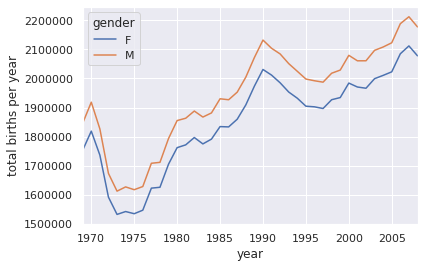

In [33]:
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

In [34]:
# Further playing with this dataset https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html